# Eye Diseases Classification

## Import Libraries

In [11]:
# SECTION 1: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Dropout, BatchNormalization, MaxPooling2D, SeparableConv2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Dataset Path and Basic Constants

In [7]:
DATASET_DIR = "Dataset/EYE_DATASET"
IMAGE_SIZE = (224, 224)

## Simple EDA (I already know the dataset is quite balanced from the Kaggle page)

In [5]:
for cls in os.listdir(DATASET_DIR):
    cls_path = os.path.join(DATASET_DIR, cls)
    if os.path.isdir(cls_path):
        count = len(os.listdir(cls_path))
        print(f"{cls}: {count} images")

cataract: 1038 images
glaucoma: 1007 images
diabetic_retinopathy: 1098 images
normal: 1074 images


## Image Preprocessing (Resizing, Normalization)

In [8]:
X = []
y = []
class_names = sorted(os.listdir(DATASET_DIR))

for label in class_names:
    folder_path = os.path.join(DATASET_DIR, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert("RGB").resize(IMAGE_SIZE)
        X.append(np.array(img) / 255.0)
        y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y)
print(f"Total images loaded: {len(X)}")

Total images loaded: 4217


## Encode Labels and Train/Test Split

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_encoded, random_state=42
)

print("Classes:", le.classes_)

Classes: ['cataract' 'diabetic_retinopathy' 'glaucoma' 'normal']


## Data Augmentation

In [17]:
# Since the dataset is already quite balanced, we can use a simple data augmentation strategy
train_aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

BATCH_SIZE = 32

val_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_gen = val_aug.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

## Model Building (a simple small CNN model)

In [18]:
def build_eye_model(img_shape, num_classes):
    img_input = Input(shape=img_shape)

    x = SeparableConv2D(32, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=img_input, outputs=output)

In [19]:
model = build_eye_model(img_shape=(224, 224, 3), num_classes=len(le.classes_))

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 28, 28, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 88,959 (347.50 KB)

 Trainable params: 87,999 (343.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
EPOCHS = 50

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,      # Batch size was set in the generator in Data Augmentation
    callbacks=callbacks
)

/home/jarvis/anaconda3/envs/StrokePredictionML/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747290392.853271  165740 service.cc:148] XLA service 0x7fcf54003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747290392.853686  165740 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-05-15 02:26:32.953918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747290393.388721  165740 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-15 02:26:35.107617: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076', 60 bytes spill stores, 64 bytes spill loads

2025-05-15 02:26:35.128681: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2076

  2/106 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2578 - loss: 1.7337  

I0000 00:00:1747290403.156416  165740 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.4230 - loss: 1.2707 - val_accuracy: 0.2607 - val_loss: 1.3952 - learning_rate: 0.0010
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.5318 - loss: 1.0476 - val_accuracy: 0.2607 - val_loss: 1.4295 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.5946 - loss: 0.9222 - val_accuracy: 0.2607 - val_loss: 1.7351 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - accuracy: 0.6363 - loss: 0.8320 - val_accuracy: 0.2500 - val_loss: 1.9315 - learning_rate: 0.0010
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.6551 - loss: 0.8038 - val_accuracy: 0.4396 - val_loss: 1.3735 - learning_rate: 0.0010
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy: 0.6774 - loss: 0.7771 - val_accuracy: 0.4159 - val_loss: 1.3211 - learning_rate: 0.0010
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.6404 - loss:

## Plot Accuracy and Loss Curves

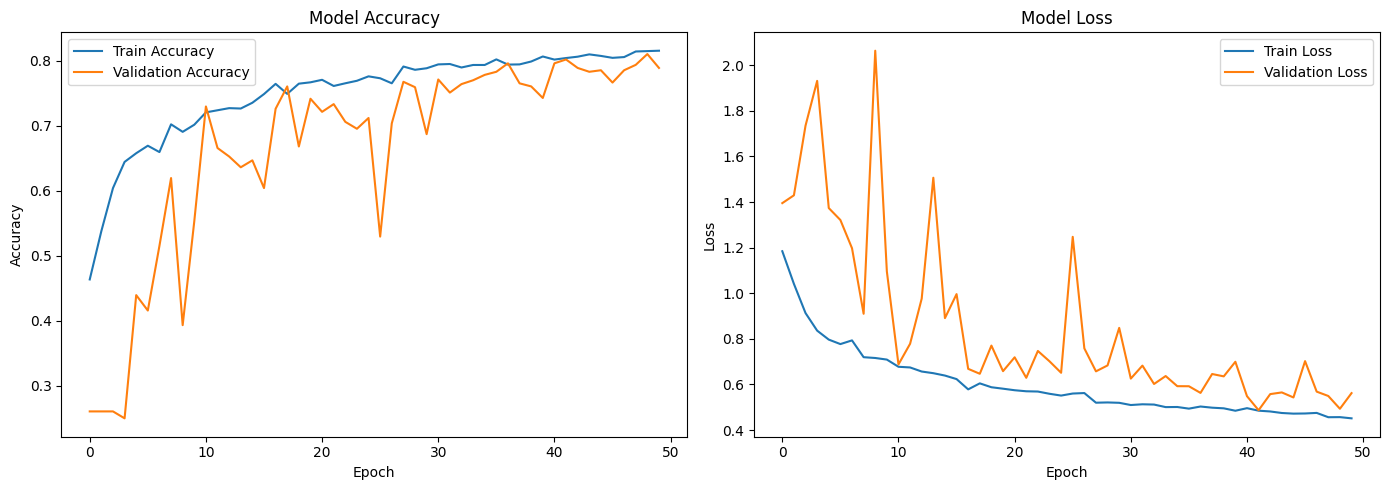

In [22]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate with Confusion Matrix and Report

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.90      0.83      0.86       208
diabetic_retinopathy       0.86      0.85      0.86       220
            glaucoma       0.79      0.68      0.73       201
              normal       0.69      0.84      0.76       215

            accuracy                           0.80       844
           macro avg       0.81      0.80      0.80       844
        weighted avg       0.81      0.80      0.80       844



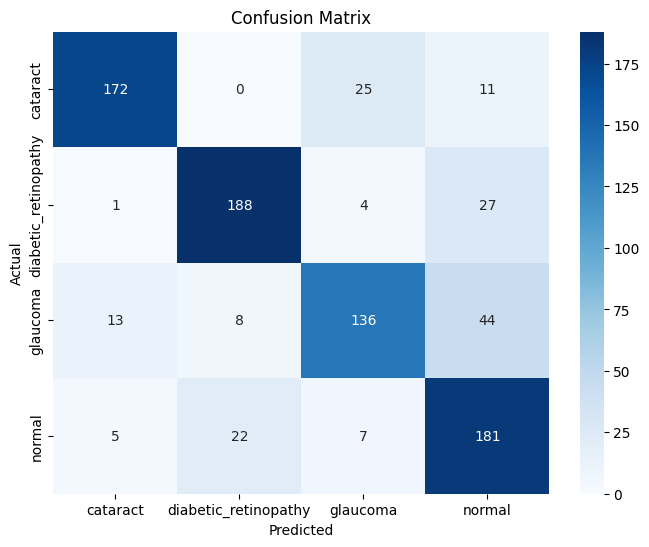

In [23]:
y_pred_probs = model.predict(val_gen)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Export Model to ONNX

In [24]:
import tf2onnx
import tensorflow as tf

# Output path
onnx_model_path = "Models/EYE_81.onnx"

# Convert the model
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=11,
    output_path=onnx_model_path
)

I0000 00:00:1747291926.683253  156621 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1747291926.683399  156621 single_machine.cc:361] Starting new session
I0000 00:00:1747291926.684417  156621 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13717 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747291926.779407  156621 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13717 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747291926.790905  156621 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1747291926.791464  156621 single_machine.cc:361] Starting new session
I0000 00:00:1747291926.791947  156621 gpu_device.cc:2022] Created device /job:localhost/repl